In [64]:
#Load libraries
pack_lib = '/home/j/temp/dccasey/temperature/packages/'
.libPaths(pack_lib)
for(ppp in c('ncdf4','raster','data.table')){
    library(ppp, lib.loc = pack_lib, character.only =T)
}
library('parallel')
library('rgdal', lib.loc = '/home/j/temp/geospatial/packages')

rgdal: version: 1.2-4, (SVN revision 643)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.7.3, released 2010/11/10
 Path to GDAL shared files: /usr/share/gdal
 GDAL does not use iconv for recoding strings.
 Loaded PROJ.4 runtime: Rel. 4.7.1, 23 September 2009, [PJ_VERSION: 470]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-3 


In [60]:
#set some paths
data.dir = '/home/j/temp/dccasey/temperature/data/'
pop.dir = '/home/j/WORK/01_covariates/02_inputs/population_counts/outputs/full_ts_1980_2015/'

In [3]:
#make all the reanalysis stuff monthly to compare with CRU
ncep_files = paste0(data.dir,'ncep_reanalysis/air.2m.gauss.',1989:2016,'.nc')
ncep = lapply(ncep_files, function(x) brick(x))

In [4]:
#make monthly means (note, the year begins 12/31 for ncep)
#ncep format is XYYYY.MM.DD.HH.MM.SS
#make a grid of months and years we want
years = 1990:2015
months = 1:12

yymm = data.table(expand.grid(year = years,month = months))
yymm = yymm[,month:= sprintf("%02d", month)]

In [5]:
#calculate the monthly mean temperature
monthly_mean_ncep = function(year, month, tlist){
  good_bricks = unlist(lapply(tlist, function(x) length(grep(paste0('X',year,'\\.',month),names(x)))>=1))
  tbrick = brick((lapply(tlist[good_bricks], function(x) x[[grep(paste0('X',year,'\\.',month),names(x))]])))
  mm_ras = mean(tbrick)
  
  #convert to celcius
  mm_ras = mm_ras- 273.15
  
  names(mm_ras) = paste0('y',year,'m',month)
  return(mm_ras)
}

In [6]:
#make monthly bricks
ncep_monthly = mclapply(1:nrow(yymm), function(x) monthly_mean_ncep(yymm[x,year],yymm[x,month],ncep), mc.cores = 10)
ncep_monthly = brick(ncep_monthly)

In [7]:
#do the reforecast stuff
refor = brick(paste0(data.dir,'reforecast/','tmp_2m_gaussian_c00_19891201_20161228_dccaVw4fMp.nc'))

In [8]:
monthly_mean_reforecast = function(year, month, tbrick){
  mm_ras = mean(tbrick)
  
  #convert to celcius
  mm_ras = mm_ras- 273.15
  
  names(mm_ras) = paste0('y',year,'m',month)
  return(mm_ras)
}

In [9]:
refor_monthly = mclapply(1:nrow(yymm), function(x) monthly_mean_reforecast(yymm[x,year],yymm[x,month],refor[[grep(paste0('X',yymm[x,year],'\\.',yymm[x,month]),names(refor))]]), mc.cores = 10)

In [10]:
refor_monthly = brick(refor_monthly)

In [22]:
#fiddle with the extent
b_e = as.vector(extent(refor_monthly))
extent(refor_monthly) = extent(-180,180,b_e[3],b_e[4])
n_e =as.vector(extent(ncep_monthly))
extent(ncep_monthly) = extent(-180,180,n_e[3],n_e[4])

In [23]:
#load the cru stuff
crus = c('1981.1990', '1991.2000','2001.2010','2011.2015')
cru = lapply(paste0(data.dir,'cru_ts/','cru_ts3.24.',crus,'.tmp.dat.nc'), function(x) brick(x))

In [24]:
#drop years we don't need
nine = names(cru[[1]])[as.numeric(substr(names(cru[[1]]),2,5))>=1990]
cru[[1]] = cru[[1]][[nine]]
#brick em all
cru = brick(cru)

In [25]:
#rename cru
names(cru) = paste0('y',gsub('\\.', "m", substr(names(cru), 2, nchar(names(cru))-3)))

In [272]:
ncep_monthly

class       : RasterBrick 
dimensions  : 94, 192, 18048, 312  (nrow, ncol, ncell, nlayers)
resolution  : 1.875, 1.904129  (x, y)
extent      : -180, 180, -89.49406, 89.49406  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 
data source : in memory
names       :  y1990m01,  y1991m01,  y1992m01,  y1993m01,  y1994m01,  y1995m01,  y1996m01,  y1997m01,  y1998m01,  y1999m01,  y2000m01,  y2001m01,  y2002m01,  y2003m01,  y2004m01, ... 
min values  : -42.87065, -39.14936, -38.59258, -46.98194, -42.46807, -43.71032, -38.04387, -41.03581, -37.94871, -38.25903, -38.17936, -37.63419, -37.65678, -35.09807, -38.87194, ... 
max values  :  33.59419,  35.22516,  32.63516,  33.84742,  34.76903,  33.37258,  35.06613,  32.44742,  34.13419,  33.94000,  32.08967,  33.71000,  33.11419,  33.90226,  33.54806, ... 


In [27]:
#resample everything to match cru (side sample for refor, downsample for ncep)
dim(cru)
dim(ncep_monthly)
dim(refor_monthly)
lapply(c(cru, ncep_monthly, refor_monthly), function(x) extent(x))

[1] 360 720 312

[1]  94 192 312

[1] 384 768 312

[[1]]
class       : Extent 
xmin        : -180 
xmax        : 180 
ymin        : -90 
ymax        : 90 

[[2]]
class       : Extent 
xmin        : -180 
xmax        : 180 
ymin        : -89.49406 
ymax        : 89.49406 

[[3]]
class       : Extent 
xmin        : -180 
xmax        : 180 
ymin        : -89.87605 
ymax        : 89.87605 


In [50]:
ncep_re = setNames(resample(ncep_monthly, cru), names(ncep_monthly))

In [51]:
refor_re = setNames(resample(refor_monthly, cru), names(refor_monthly))

In [57]:
#fix names
names(ncep_re) = names(ncep_monthly)
names(refor_re) = names(refor_monthly)

In [42]:
#make a cru mask
cru_mask = !is.na(cru[[1]])
cru_mask[cru_mask == 0] = NA

In [52]:
#apply the mask
ncep_re = ncep_re * cru_mask
refor_re = refor_re * cru_mask

In [58]:
lapply(c(ncep_re, refor_re, cru), function(x) names(x)[1:10])

[[1]]
 [1] "y1990m01" "y1991m01" "y1992m01" "y1993m01" "y1994m01" "y1995m01"
 [7] "y1996m01" "y1997m01" "y1998m01" "y1999m01"

[[2]]
 [1] "y1990m01" "y1991m01" "y1992m01" "y1993m01" "y1994m01" "y1995m01"
 [7] "y1996m01" "y1997m01" "y1998m01" "y1999m01"

[[3]]
 [1] "y1990m01" "y1990m02" "y1990m03" "y1990m04" "y1990m05" "y1990m06"
 [7] "y1990m07" "y1990m08" "y1990m09" "y1990m10"

In [74]:
#make a population mask
pop_files = paste0(pop.dir, 'glp',1990:2016,'ag.tif')

In [68]:
pop1990 = raster(paste0(pop.dir, 'glp',1990:2016,'ag.tif')[1])

In [73]:
#load pops
load_pop = function(file_name, basegrid){
    pop=raster(file_name)
    fact = round(dim(pop)[1:2] / dim(basegrid)[1:2])
    pop = aggregate(pop, fact)
    pop = resample(pop, basegrid)
    return(pop)
}


In [248]:
#load pops
pop = mclapply(pop_files, function(x) load_pop(x, cru_mask),mc.cores = 9)

In [249]:
pop = brick(pop)
pop = pop * cru_mask

In [250]:
names(pop) = paste0('pop',1990:2016)

In [266]:
#make a pop_mask
pop_mask = pop>1

In [267]:
pop_mask[pop_mask==0] = NA

In [268]:
names(pop_mask) = names(pop)

In [269]:
#pop mask temp
pop_mask_temp =function(year, pop_m, temper_objs){
    #subset to the relevant years
    pm = pop_m[[paste0('pop',year)]]
    
    t_o = lapply(temper_objs, function(x) x[[grep(year, names(x))]])
        
    #convert all to dataframe
    names(pm) = 'pop_mask'
    pm = as.data.frame(pm, xy = T)
    t_o = lapply(1:length(t_o), function(x) as.data.frame(t_o[[x]]))
        
    #set names of t_o
    t_o = lapply(1:length(t_o), function(x) setNames(t_o[[x]], paste0(names(temper_objs)[[x]],'_',names(t_o[[x]]))))
    
    ret_obj = as.data.table(do.call(cbind, c(pm, t_o)))
    ret_obj = ret_obj[!is.na(pop_mask),]
        
    #reshape long
    #get unique month and days
    pos_names = grep('y[0-9][0-9][0-9][0-9]m[0-9][0-9]',names(ret_obj),value = T)
    ym = unique(substr(pos_names, nchar(pos_names)-7, nchar(pos_names)))
        
    ret_obj = melt(ret_obj, measure = lapply(names(temper_objs), function(x) paste0(x,'_',ym)), value.name = names(temper_objs),variable.factor =F)
        
    setnames(ret_obj, 'variable', 'month')
    ret_obj = ret_obj[,the_year := year]
    
    return(ret_obj)
}

In [270]:
#make pop mask temps
pm_temp = lapply(1990:2015, function(yyy) pop_mask_temp(year = yyy, pop_m = pop_mask, temper_objs = list(cru = cru, ncep = ncep_re, refor = refor_re)))

In [271]:
lapply(pm_temp, function(x) cor(x[,.(ncep, refor, cru)]))

,ncep,refor,cru
ncep,1.0000000,0.9777497,0.7965946
refor,0.9777497,1.0000000,0.7779208
cru,0.7965946,0.7779208,1.0000000
,ncep,refor,cru
ncep,1.0000000,0.9769855,0.7881722
refor,0.9769855,1.0000000,0.7716071
cru,0.7881722,0.7716071,1.0000000
,ncep,refor,cru
ncep,1.0000000,0.9778052,0.7931098
refor,0.9778052,1.0000000,0.7712130


In [273]:
#combine all the temps
pm_temp_all = rbindlist(pm_temp)

In [276]:
cor(pm_temp_all[,.(ncep, refor, cru)])

,ncep,refor,cru
ncep,1.0000000,0.9774444,0.7893380
refor,0.9774444,1.0000000,0.7745351
cru,0.7893380,0.7745351,1.0000000


In [284]:
pm_temp_all[1:3,]

x,y,pop_mask,month,cru,ncep,refor,the_year
18.25,69.75,TRUE,1,-6.4,-26.37200,-28.80899,1990
18.75,69.75,TRUE,1,-5.6,-26.55319,-29.54816,1990
19.25,69.75,TRUE,1,-7.3,-26.73437,-30.08942,1990


In [285]:
names(refor_re)[1:10]

[1] "y1990m01" "y1991m01" "y1992m01" "y1993m01" "y1994m01" "y1995m01"
 [7] "y1996m01" "y1997m01" "y1998m01" "y1999m01"

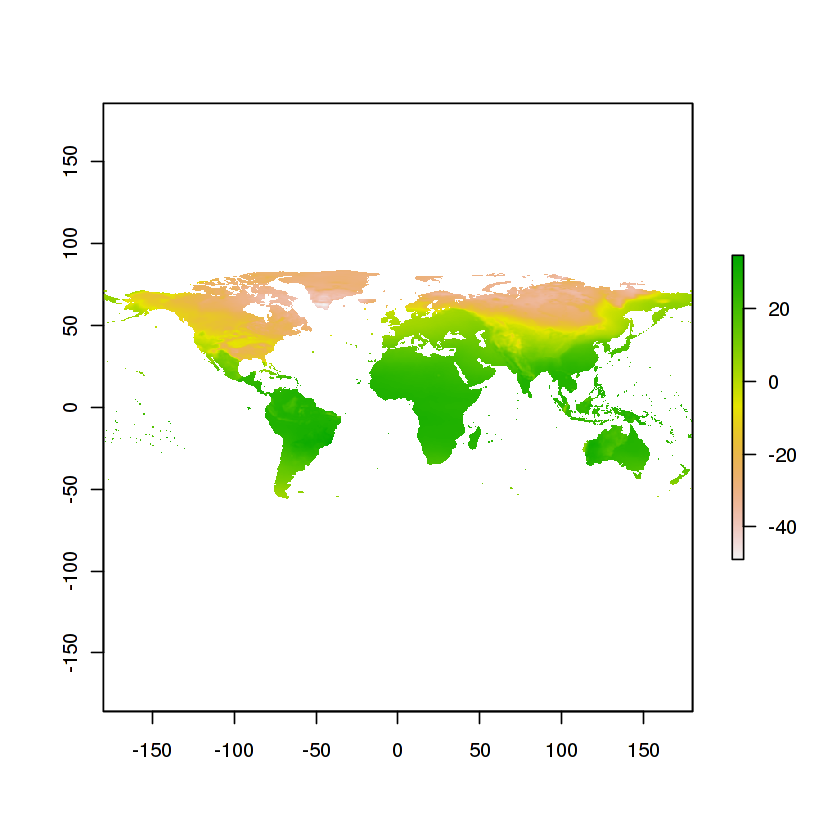

In [286]:
plot(refor_re[['y1990m01']])

In [288]:
extract(refor_re[['y1990m01']],pm_temp_all[1:3,.(x,y)])

[1] -28.80899 -29.54816 -30.08942

In [289]:
extract(cru[['y1990m01']],pm_temp_all[1:3,.(x,y)])

Warning message in file(fn, "rb"):
“cannot open file '/tmp/RtmpjCwANz/raster/r_tmp_2017-01-03_103529_44607_75736.gri': No such file or directory”

ERROR: Error in file(fn, "rb"): cannot open the connection
